In [35]:
# ====================================================================================================
# Nome do Arquivo : Regressao_Logistica.ipynb
# Autores         : Débora Leandro de Andrade e Juan Diego de Paula Rollemberg
# Curso           : PES - Colaborador Embraer
# Disciplina      : Aprendizagem de máquina I
# Professor       : George Darmilton
# Data            : 03/08/2025
# ====================================================================================================

#Esse script tem como objetivo ler o dataset selecionado e aplicar o algoritmo Regressão Logística.
#É realizado um treinamento considerando todos os atributos.

In [36]:
#instalação das bibliotecas de manipualção e visualização de dados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import seaborn as sns

#acesso ao dataset
from sklearn.datasets import fetch_openml

#classes do modelo de aprendizado
from sklearn.linear_model import LogisticRegression

#funções de avaliação dos modelos
from sklearn.metrics import classification_report, mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [37]:
#fetch dataset
X,y = fetch_openml(data_id=46880, return_X_y=True)

dataset = pd.concat([X,y], axis=1)

dataset.head()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air_Quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,Moderate
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,Moderate
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,Moderate
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,Good
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,Good


In [38]:
#definindo semente
seed=42

#seleciona todos os campos menos a classe alvo para a variável "X".
X = dataset.iloc[:,:-1]
y = dataset.loc[:,"Air_Quality"]

#separando o conjunto de dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
print(X_train.shape)
print(X_test.shape)

(3500, 9)
(1500, 9)


In [39]:
model = LogisticRegression(random_state=seed)

param_grid = {
     #algoritmos usados para otimizar a função de custo
    'solver': ['lbfgs', 'liblinear', 'saga'],

     #tipo de regularização: L1: Penaliza a soma dos valores absolutos | L2: Penaliza a soma dos quadrados
    'penalty': ['l1','l2', None],

    #Numero máximo de iterações até a convergência
    'max_iter': [100, 200, 300]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

#treinar o modelo usando Grid Search
grid_search.fit(X_train, y_train)

#predição com o melhor modelo encontrado
y_pred = grid_search.predict(X_test)

#resultados do classificador
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Best parameters found:  {'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score:  0.8788571428571428


              precision    recall  f1-score   support

        Good       0.98      1.00      0.99       618
   Hazardous       0.87      0.80      0.84       148
    Moderate       0.80      0.93      0.86       452
        Poor       0.78      0.58      0.66       282

    accuracy                           0.88      1500
   macro avg       0.86      0.83      0.84      1500
weighted avg       0.88      0.88      0.87      1500



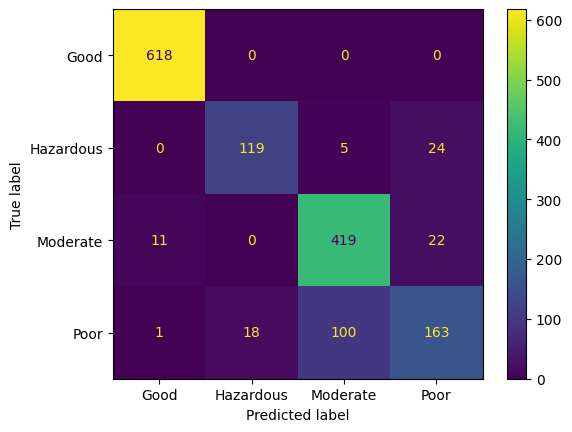



Acurácias por fold: [0.872 0.846 0.88  0.89  0.884 0.886 0.892 0.868 0.908 0.886]
Acurácia média: 0.8812000000000001
K-fold: 0.881 ± 0.016




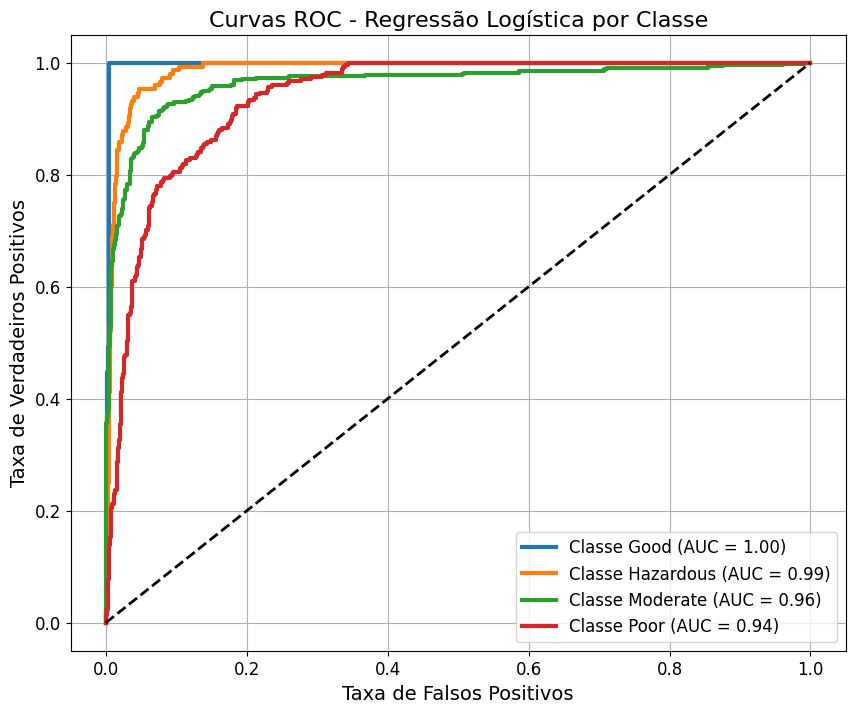

In [40]:
#definindo o modelo com os melhores parâmetros
model = LogisticRegression(random_state=seed, **grid_search.best_params_)

#treinando o modelo
model.fit(X_train, y_train)

#predição
y_pred = model.predict(X_test)

#relatório do classificador
print(classification_report(y_test, y_pred))

#calcula a matriz de confusão de acordo com os parâmetros acima
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)

disp_cm.plot()

plt.show()

print('\n')

#10-fold cross validation
kf = KFold(n_splits=10)

scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

print("Acurácias por fold:", scores)
print("Acurácia média:", scores.mean())
print("K-fold: %.3f ± %.3f" % (scores.mean(), scores.std()))
print('\n')

#cálculo das curvas ROC para cada classe
y_pred_prob = model.predict_proba(X_test)

classes = sorted(y.unique())

y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Classe {classes[i]} (AUC = {roc_auc:.2f})', linewidth=3)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlabel('Taxa de Falsos Positivos', fontsize=14)
plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=14)
plt.title('Curvas ROC - Regressão Logística por Classe', fontsize=16)
plt.legend(loc='lower right',fontsize=12)
plt.grid(True)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()